In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from torchvision import datasets,transforms

In [2]:
import matplotlib.pyplot as plt

In [3]:
train_transforms = transforms.Compose([transforms.CenterCrop(24),transforms.Resize(28),transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081))])
test_transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))])

In [4]:
train_set = datasets.MNIST('../data',train=True,download=True,transform=train_transforms)
test_set = datasets.MNIST('../data',train=False,download=True,transform=test_transforms)

In [5]:
batch_size  = 128
train_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=False)

In [6]:

def show_imgs(imgs,labels):
  fig = plt.figure(figsize=(5,5))
  axs = fig.subplots(4,7)
  for i in range(4):
    for j in range(7):
      axs[i][j].imshow(imgs[i+j].reshape(28,28),cmap='gray')
      axs[i][j].set_xlabel(labels[i+j].item())
      axs[i][j].tick_params(left=False,bottom=False,labelleft=False,labelbottom=False,right=False)
  plt.show()






In [7]:
imgs,lbls = next(iter(train_loader))

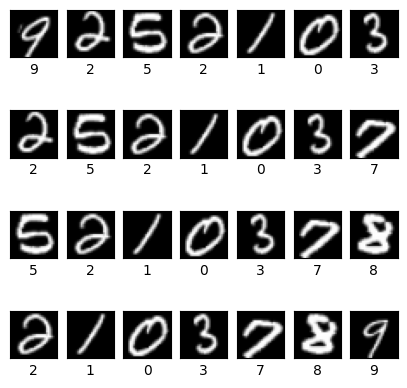

In [8]:
show_imgs(imgs,lbls)

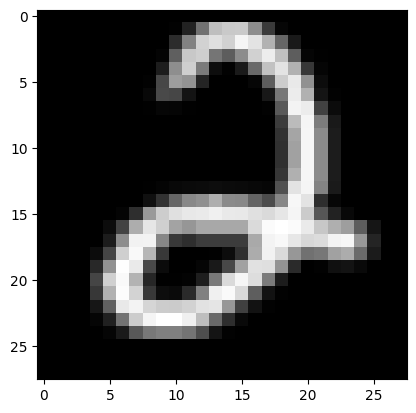

In [9]:
plt.imshow(imgs[1].reshape(28,28),cmap='gray')


In [27]:
# class MNet(nn.Module):
#   def __init__(self):
#     super(MNet,self).__init__()
#     self.conv1 = nn.Conv2d(1,64,3)
#     self.conv2 = nn.Conv2d(64,128,1)
#     self.pool1 = nn.MaxPool2d(2,2)
#     self.conv3 = nn.Conv2d(128,64,1)
#     self.bt_nm = nn.BatchNorm2d(64)
#     self.conv4 = nn.Conv2d(64,32,1)
#     self.gav1 = nn.AvgPool2d(13)
#     self.conv5 = nn.Conv2d(32,10,1)

#   def forward(self,x):
#     x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
#     x = self.bt_nm(F.relu(self.conv3(x)))
#     x = F.relu(self.conv5(self.gav1(F.relu(self.conv4(x)))))
#     x = x.view(-1,10)
#     return F.log_softmax(x)


In [28]:
# !pip install torchsummary
# from torchsummary import summary
# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# model = MNet().to(device)
# summary(model, input_size=(1, 28, 28))

In [ ]:
!pip install tqdm

In [10]:

# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}


In [11]:
from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))


def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [26]:
# model = MNet().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# # New Line
# criterion = nn.CrossEntropyLoss(reduction="sum")
# num_epochs = 20
# for epoch in range(1, num_epochs+1):
#   print(f'Epoch {epoch}')
#   train(model, device, train_loader, optimizer, criterion)
#   test(model, device, train_loader, criterion)
#   scheduler.step()

In [23]:
class MNet2(nn.Module):
  def __init__(self):
    super(MNet2,self).__init__()
    self.conv1 = nn.Conv2d(1,32,3)
    self.conv2 = nn.Conv2d(32,36,3)
    self.pool1 = nn.MaxPool2d(2,2)
    self.conv3 = nn.Conv2d(36,24,3)
    self.bt_nm = nn.BatchNorm2d(24)
    self.conv4 = nn.Conv2d(24,16,1)
    self.conv5 = nn.Conv2d(16,10,1)
    self.gav1 = nn.AvgPool2d(10)

  def forward(self,x):
    x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
    x = self.bt_nm(F.relu(self.conv3(x)))
    x = self.gav1(F.relu(self.conv5(F.relu(self.conv4(x)))))
    x = x.view(-1,10)
    return F.log_softmax(x,dim=1)

In [24]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = MNet2().to(device)
summary(model, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 36, 24, 24]          10,404
         MaxPool2d-3           [-1, 36, 12, 12]               0
            Conv2d-4           [-1, 24, 10, 10]           7,800
       BatchNorm2d-5           [-1, 24, 10, 10]              48
            Conv2d-6           [-1, 16, 10, 10]             400
            Conv2d-7           [-1, 10, 10, 10]             170
         AvgPool2d-8             [-1, 10, 1, 1]               0
Total params: 19,142
Trainable params: 19,142
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.42
Params size (MB): 0.07
Estimated Total Size (MB): 0.50
----------------------------------------------------------------


In [25]:
model = MNet2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = nn.CrossEntropyLoss(reduction="sum")
num_epochs = 20
for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, train_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=69.2635 Batch_id=468 Accuracy=51.20: 100%|██████████| 469/469 [00:33<00:00, 14.01it/s]


Test set: Average loss: 1.2782, Accuracy: 36631/60000 (61.05%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=25.2175 Batch_id=468 Accuracy=82.19: 100%|██████████| 469/469 [00:26<00:00, 17.96it/s]


Test set: Average loss: 0.4894, Accuracy: 50667/60000 (84.44%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=36.5490 Batch_id=468 Accuracy=89.02: 100%|██████████| 469/469 [00:25<00:00, 18.11it/s]


Test set: Average loss: 0.4929, Accuracy: 52544/60000 (87.57%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=8.4659 Batch_id=468 Accuracy=91.20: 100%|██████████| 469/469 [00:26<00:00, 18.00it/s]


Test set: Average loss: 0.2537, Accuracy: 55386/60000 (92.31%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=8.6708 Batch_id=468 Accuracy=93.62: 100%|██████████| 469/469 [00:26<00:00, 17.85it/s]


Test set: Average loss: 0.1765, Accuracy: 56921/60000 (94.87%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=20.9621 Batch_id=468 Accuracy=94.04: 100%|██████████| 469/469 [00:26<00:00, 17.61it/s]


Test set: Average loss: 0.2880, Accuracy: 55009/60000 (91.68%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=13.4159 Batch_id=468 Accuracy=94.42: 100%|██████████| 469/469 [00:26<00:00, 17.39it/s]


Test set: Average loss: 0.2049, Accuracy: 56167/60000 (93.61%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=24.9911 Batch_id=468 Accuracy=94.45: 100%|██████████| 469/469 [00:26<00:00, 17.86it/s]


Test set: Average loss: 0.1413, Accuracy: 57496/60000 (95.83%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=26.2817 Batch_id=468 Accuracy=95.09: 100%|██████████| 469/469 [00:25<00:00, 18.19it/s]


Test set: Average loss: 0.1854, Accuracy: 56891/60000 (94.82%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=23.6487 Batch_id=468 Accuracy=95.49: 100%|██████████| 469/469 [00:25<00:00, 18.21it/s]


Test set: Average loss: 0.1521, Accuracy: 57664/60000 (96.11%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=21.3136 Batch_id=468 Accuracy=95.11: 100%|██████████| 469/469 [00:26<00:00, 17.79it/s]


Test set: Average loss: 0.1422, Accuracy: 57594/60000 (95.99%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=18.7947 Batch_id=468 Accuracy=95.85: 100%|██████████| 469/469 [00:26<00:00, 17.48it/s]


Test set: Average loss: 0.2158, Accuracy: 56786/60000 (94.64%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=8.5489 Batch_id=468 Accuracy=95.58: 100%|██████████| 469/469 [00:26<00:00, 17.60it/s]


Test set: Average loss: 0.1797, Accuracy: 56873/60000 (94.79%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=12.0048 Batch_id=468 Accuracy=95.48: 100%|██████████| 469/469 [00:26<00:00, 17.77it/s]


Test set: Average loss: 0.1895, Accuracy: 56962/60000 (94.94%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=15.9904 Batch_id=468 Accuracy=96.07: 100%|██████████| 469/469 [00:26<00:00, 17.49it/s]


Test set: Average loss: 0.1198, Accuracy: 57968/60000 (96.61%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=7.5693 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:26<00:00, 17.51it/s]


Test set: Average loss: 0.0630, Accuracy: 58880/60000 (98.13%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=4.5124 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:26<00:00, 17.44it/s]


Test set: Average loss: 0.0564, Accuracy: 58984/60000 (98.31%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=4.6807 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:27<00:00, 17.02it/s]


Test set: Average loss: 0.0512, Accuracy: 59064/60000 (98.44%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=2.6936 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:26<00:00, 17.71it/s]


Test set: Average loss: 0.0503, Accuracy: 59105/60000 (98.51%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=4.2820 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:27<00:00, 17.25it/s]


Test set: Average loss: 0.0486, Accuracy: 59118/60000 (98.53%)

Adjusting learning rate of group 0 to 1.0000e-03.
